<a href="https://colab.research.google.com/github/andrei-radulescu-banu/stat453-deep-learning-ss21/blob/main/L12/code/experiment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

STAT 453: Deep Learning (Spring 2021)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2021/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss21

---

In [1]:
!pip install watermark
!pip install colab-env --upgrade
import colab_env
colab_env.envvar_handler.add_env("CUBLAS_WORKSPACE_CONFIG", ":4096:8", overwrite=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 30.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for colab-env: filename=colab_env-0.2.0-py3-none-any.whl size=3838 sha256=0c0935ea74367e90ef8a69642ccd7d6e3461bbd2404efbd6184bd1d645cd5f2d
  Stored in directory: /root/.cache/pip/wheels/bb/ca/e8/3d25b6abb4ac719ecb9e837bb75f2a9b980430005fb12a9107
Successfully built colab-env
Mounted at /content/gdrive


In [2]:
%load_ext watermark
%watermark -a 'Andrei R-B' -v -p torch

Author: Andrei R-B

Python implementation: CPython
Python version       : 3.7.15
IPython version      : 7.9.0

torch: 1.12.1+cu113



# MLP with Dropout 

## Imports

In [3]:
!git clone https://github.com/andrei-radulescu-banu/stat453-deep-learning-ss21.git

Cloning into 'stat453-deep-learning-ss21'...
remote: Enumerating objects: 1163, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 1163 (delta 58), reused 4 (delta 4), pack-reused 1050
Receiving objects: 100% (1163/1163), 114.98 MiB | 14.03 MiB/s, done.
Resolving deltas: 100% (162/162), done.


In [4]:
!ls /content/stat453-deep-learning-ss21/L12/code

adabelief.ipynb		adamW.ipynb	      helper_plotting.py
adam-experiment1.ipynb	batchsize-1024.ipynb  helper_train.py
adam-experiment2.ipynb	batchsize-64.ipynb    scheduler.ipynb
adam-experiment3.ipynb	experiment5.ipynb     sgd-scheduler-momentum.ipynb
adam-experiment4.ipynb	helper_dataset.py
adam.ipynb		helper_evaluation.py


In [5]:
import sys, os
sys.path.append("/content/stat453-deep-learning-ss21/L12/code")

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [59]:
from torchvision import datasets
import torchvision
import random
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
import torch.nn.functional as F
import torch
import PIL

In [7]:
# From local helper files
from helper_evaluation import set_all_seeds, set_deterministic
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples
from helper_dataset import get_dataloaders_mnist

## Settings and Dataset

In [48]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 123
BATCH_SIZE = 256
NUM_HIDDEN_1 = 75
NUM_HIDDEN_2 = 45
NUM_EPOCHS = 100
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [84]:
set_all_seeds(RANDOM_SEED)
set_deterministic()

In [82]:
##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range

training_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(32, 32)),
    torchvision.transforms.RandomCrop(size=(28, 28)),
#    torchvision.transforms.RandomRotation(degrees=30),
    torchvision.transforms.RandomAffine(degrees=30),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.5,), std=(0.5,)),
    # normalize does (x_i - mean) / std
    # if images are [0, 1], they will be [-1, 1] afterwards
])

valid_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=(32, 32)),
    torchvision.transforms.CenterCrop(size=(28, 28)),
    torchvision.transforms.Normalize(mean=(0.5,), std=(0.5,)),
])

# for more see
# https://pytorch.org/docs/stable/torchvision/transforms.html

Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
Class labels of 10 examples: tensor([4, 5, 8, 9, 9, 4, 9, 9, 3, 9])


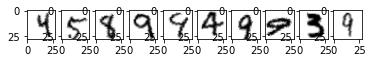

Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
Class labels of 10 examples: tensor([4, 2, 9, 9, 8, 6, 8, 8, 9, 3])


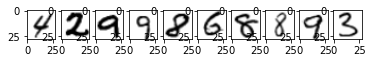

In [85]:
##########################
### MNIST DATASET
##########################

train_loader, valid_loader, test_loader = get_dataloaders_mnist(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=training_transforms,
    test_transforms=validation_transforms)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

num_images = 10
fig, ax = plt.subplots(1, num_images)
for i in range(num_images):
    ax[i].imshow(images[i].view(28, 28).numpy(), cmap='binary')

plt.show()

for images, labels in valid_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

num_images = 10
fig, ax = plt.subplots(1, num_images)
for i in range(num_images):
    ax[i].imshow(images[i].view(28, 28).numpy(), cmap='binary')

plt.show()

## Model

In [86]:
class MultilayerPerceptron(torch.nn.Module):

    def __init__(self, num_features, num_classes, drop_proba, 
                 num_hidden_1, num_hidden_2):
        super().__init__()
        
        self.my_network = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Flatten(),
            torch.nn.Linear(num_features, num_hidden_1, bias=False),
            torch.nn.BatchNorm1d(num_hidden_1),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            # 2nd hidden layer
            torch.nn.Linear(num_hidden_1, num_hidden_2, bias=False),
            torch.nn.BatchNorm1d(num_hidden_2),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            # output layer
            torch.nn.Linear(num_hidden_2, num_classes)
        )
           
    def forward(self, x):
        logits = self.my_network(x)
        return logits

In [ ]:
torch.manual_seed(RANDOM_SEED)
model = MultilayerPerceptron(num_features=28*28,
                             num_hidden_1=NUM_HIDDEN_1,
                             num_hidden_2=NUM_HIDDEN_2,
                             drop_proba=0.5,
                             num_classes=10)
model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.5) # Use SGD instead of Adam
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='min',
                                                       verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    logging_interval=100,
    scheduler=scheduler,
    scheduler_on='valid_acc')

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=20)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([80, 100])
plt.show()

Epoch: 001/100 | Batch 0000/0210 | Loss: 2.3465
Epoch: 001/100 | Batch 0100/0210 | Loss: 1.1556
Epoch: 001/100 | Batch 0200/0210 | Loss: 0.9301
